# Exercise 2

#### Andrea Barbon

<br/><br/>

In [24]:
import numpy as np
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
# Number of neurons in each layer
NEURONS = [ 2, 3, 1 ]

# input the dataset
TRAIN_X1 = [ 4, 4, 5, 5, 7,      1,  2,  3,  6,  3,  6,  4,  7 ]
TRAIN_X2 = [ 2, 4, 3, 1, 2,      2,  1,  1,  5,  6,  7,  6,  6 ]
TRAIN_Z  = [ 1, 1, 1, 1, 1,     -1, -1, -1, -1, -1, -1, -1, -1 ]
TRAIN_N  = len(TRAIN_X1)
TRAIN_X0 = np.ones(TRAIN_N)

TEST_X1 = [ 4, 5, 3, 5, 6, 7,    3,  8,  4,  7,  2,  2 ]
TEST_X2 = [ 1, 2, 4, 4, 1, 1,    2,  7,  7,  5,  3,  5 ]
TEST_Z  = [ 1, 1, 1, 1, 1, 1,   -1, -1, -1, -1, -1, -1 ]
TEST_N  = len(TEST_X1)
TEST_X0 = np.ones(TEST_N)

TRAIN_X = np.array( [TRAIN_X0, TRAIN_X1, TRAIN_X2] ).T
TEST_X  = np.array( [TEST_X0, TEST_X1, TEST_X2] ).T

# A)

In [3]:
def plot_set(h,X1,X2, ax=plt, title='Set'):
    ax.scatter(x=X1[:h], y=X2[:h], color='b' )
    ax.scatter(x=X1[h:], y=X2[h:], color='r' )
    ax.set_title( title )

fig, (ax1, ax2) = plt.subplots( 1,2, figsize=(16,5) )

plot_set(5, TRAIN_X1, TRAIN_X2, ax1, 'Training Set')
plot_set(5, TEST_X1 , TEST_X2 , ax2, 'Tes Set'     )

No, a linear Neural Network would **not** be able to solve the problem.

The reason is that the sets are not linearly separable, i.e. there exist no line separating blue dots from red dots.

# B) and C)

The formulas for the forward pass can be written as
$ o^{(1)} = \sigma( w^{(1)} \hat{o} ) $
and
$ o^{(2)} = w^{(2)} \hat{o}^{(1)} $
where the $w$'s contain the weight for the bias and $\hat{x} = (1, x) $.

The formulas for the backward pass can be written as
$$ \delta^{(2)} =  \frac{\partial E}{\partial net^{(2)}}  = (o^{(2)} − z ) $$
and
$$ \delta_j^{(1)} 
= \frac{\partial E}{\partial net^{(1)}} 
= \sigma'( net^{(1)} ) w_{j}^{(2)} \delta^{(2)} 
= o_j^{(1)}(1 − o_j^{(1)}) w_{j}^{(2)} \delta^{(2)} $$

Weights are updated using
$$ \Delta w_{i}^{(2)} = − \eta \, o_i^{(1)} \, \delta^{(2)}, \qquad i=0,\dots,3 \quad $$

and

$$ \Delta w_{i,j}^{(1)} = − \eta \, o_{i} \, \delta_j^{(1)}, \qquad 0=1,\dots,2 \quad , \quad j=0,\dots,3 $$

# D)

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def step(x):
    return np.where( x > 0, 1, -1 )

def present_results(epochs, testPerfs, error_TSs, eta=0.1):
    
    print('Eta: {0}'.format(eta) )
    print( 'Average   epochs: {0:1.2f}'.format( np.mean( epochs ) ) )
    print( 'Std. dev. epochs: {0:1.2f}'.format( np.std ( epochs ) ) )
    #print()
    print( 'Average   test performance: {0:1.2f}'.format( np.mean( testPerfs ) ) )
    print( 'Std. dev. test performance: {0:1.2f}'.format( np.std ( testPerfs ) ) )
    print()
    print()

    # Padding
    lenghts = [ len(x) for x in error_TSs ]
    L = np.max( lenghts )
    error_TSs_pad  = [ np.pad( x, (0,L-len(x)), 'constant', constant_values=0 ) for x in error_TSs]
    error_TSs_mean = np.mean( error_TSs_pad, axis=0 )
    
    W = 100
    moving_avg = np.zeros( int(L / W) )
    for i in range( int(L / W) - 1):
        moving_avg[i] = np.mean( error_TSs_mean[ i*W : (i+1)*W ] )
    moving_avg[int(L / W)-1] = np.mean( error_TSs_mean[ (i)*W :] )

    # Plotting
    domain = [ x*W for x in range(0,len(moving_avg)) ]
    plt.plot( domain , moving_avg, label='Error with eta = {0}'.format(eta)   )
    _ = plt.legend()

In [59]:
n = NEURONS[0]
k = NEURONS[1]
m = NEURONS[2]

def TestPerformance(W1,W2):
    O_   = TEST_X
    O    = TEST_X[:,1:]
    net1 = np.dot( O_, W1 )
    O1   = sigmoid(net1)
    O1_ = np.ones( (TEST_N, NEURONS[1] + 1) )
    O1_[:, 1:] = O1
    O2   = np.dot( O1_, W2 )
    total_error = 0
    for s in range( 0, TEST_N ):
        total_error += np.abs( ( step(O2)[s] - TRAIN_Z[s] ) ) * 0.5
    return total_error

def TrainAndTest(W1, W2, eta=0.1, EPOCHS=30000):
    
    error_TS = []
    
    for epoch in range( EPOCHS+1 ):

        total_error = 0

        # Step 1 : feed-forward computation
        O_   = TRAIN_X
        O    = TRAIN_X[:,1:]
        net1 = np.dot( O_, W1 )
        O1   = sigmoid(net1)
        O1_  = np.ones( (TRAIN_N, NEURONS[1] + 1) )
        O1_[:, 1:] = O1
        O2   = np.dot( O1_, W2 )

        # Step 2 : backpropagation to the output layer
        del_2 = ( step(O2).T - TRAIN_Z ).T
        
        # Step 3 : backpropagation to the hidden layer
        del_1 = O1 * (1 - O1) * W2[1:].T * del_2

        # Step 4 : weight updates
        del_w_1 = np.zeros( [ n+1, k ] )
        del_w_2 = np.zeros( [ k+1, m ] )
        for s in range( TRAIN_N ):
            del_w_1 += - eta * np.outer( O_[s] , del_1[s] ) / TRAIN_N
            del_w_2 += - eta * np.outer( O1_[s], del_2[s] ) / TRAIN_N
            total_error += np.abs( ( step(O2)[s] - TRAIN_Z[s] ) ) * 0.5
        W1 += del_w_1
        W2 += del_w_2

        error_TS.append( total_error[0] )

        if total_error == 0 : break
    
    testPerf = TestPerformance(W1,W2)
    
    return epoch, testPerf, error_TS

Eta: 0.1
Average   epochs: 1445.00
Std. dev. epochs: 0.00
Average   test performance: 4.00
Std. dev. test performance: 0.00




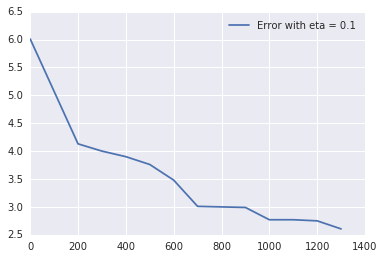

In [67]:
W1 = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
W2 = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )
epoch, testPerf, error_TS = TrainAndTest(W1, W2)
error_TS = [error_TS]
present_results(epoch, testPerf, error_TS)

# E)

In [60]:
%%time
epochs    = []
testPerfs = []
error_TSs = []
for r in range(10):
    W1 = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
    W2 = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )
    epoch, testPerf, error_TS = TrainAndTest(W1, W2)
    epochs   .append( epoch    )
    testPerfs.append( testPerf )
    error_TSs.append( error_TS )

Wall time: 18.4 s


Eta: 0.1
Average   epochs: 1552.70
Std. dev. epochs: 265.69
Average   test performance: 3.20
Std. dev. test performance: 0.75




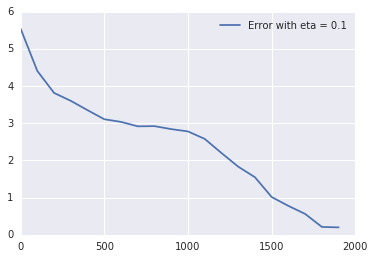

In [62]:
present_results(epochs, testPerfs, error_TSs)

It takes $1552.7$ epochs on average to classify all the points.
I notice that the out-of-sample performance is quite bad.

# F)

In [63]:
%%time

results = {}

for eta in [10, 1, 1/10, 1/100, 1/1000]:
    
    print('Eta: {0}'.format(eta) )

    epochs    = []
    testPerfs = []
    error_TSs = []

    for r in range(10):
        # Random initial weights ( Including Bias )
        W1 = np.random.uniform( -.1, .1, size=( NEURONS[0]+1, NEURONS[1] ) )
        W2 = np.random.uniform( -.1, .1, size=( NEURONS[1]+1, NEURONS[2] ) )
        epoch, testPerf, error_TS = TrainAndTest(W1, W2, eta)
        epochs   .append( epoch    )
        testPerfs.append( testPerf )
        error_TSs.append( error_TS )
    
    results[eta] = epochs, testPerfs, error_TSs

Eta: 10
Eta: 1
Eta: 0.1
Eta: 0.01
Eta: 0.001
Wall time: 11min 47s


Eta: 10
Average   epochs: 30000.00
Std. dev. epochs: 0.00
Average   test performance: 5.20
Std. dev. test performance: 0.60


Eta: 1
Average   epochs: 1415.80
Std. dev. epochs: 242.46
Average   test performance: 4.00
Std. dev. test performance: 0.00


Eta: 0.1
Average   epochs: 1361.90
Std. dev. epochs: 178.83
Average   test performance: 3.30
Std. dev. test performance: 0.46


Eta: 0.01
Average   epochs: 19105.60
Std. dev. epochs: 6509.79
Average   test performance: 2.60
Std. dev. test performance: 0.80


Eta: 0.001
Average   epochs: 30000.00
Std. dev. epochs: 0.00
Average   test performance: 4.80
Std. dev. test performance: 0.40




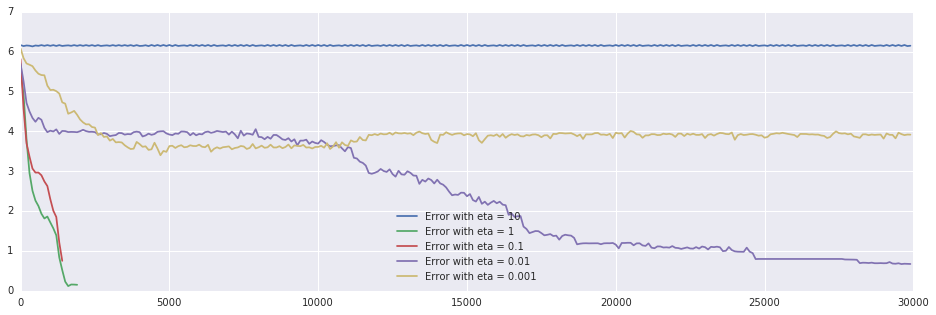

In [65]:
fig = plt.figure(figsize=(16, 5)) 
for eta in [10, 1, 1/10, 1/100, 1/1000]:
    present_results( *results[eta], eta )
_   = plt.legend(loc=0)

A learning rate of $10$ does not work, most likely because the gradiend descend overshoots the global minimum.

For the other learning rates, I notice a trade-off between the speed of learning and the out-of-sample performance:
- Lowering $\eta$ increases the average number of epochs needed for full classification
- Lowering $\eta$ improves the out-of-sample performance

In the case $\eta= 1/1000$ the optimization did not converge to the minumum after $30,000$ epochs.
Most likely letting it run for more epochs would lead to full in-sample classification and a better out-of-sample performance 

<br/><br/><br/><br/>

<br/><br/><br/><br/>
___

Taking inspiration from the book [Neural Networks](https://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf) by R. Rojas.

![Network](Network.png "Network")

### First step: feed-forward computation
The vector $o$ is presented to the network. The vectors $o^{(1)}$ and $o^{(2)}$ are computed and stored. The evaluated derivatives of the activation functions are also stored at each unit.

### Second step: backpropagation to the output layer
We are looking for the first set of partial derivatives $ \partial E/\partial w_{i,j}^{(2)} = \delta_j^{(2)} o_i^{(1)} $, where

$$ \delta_j^{(2)} = o_j^{(2)}(1 − o_j^{(2)})(o_j^{(2)} − t_j ) $$

### Third step: backpropagation to the hidden layer
￼Now we want to compute the partial derivatives $\partial E/ \partial w^{(1)}$. Each unit $j$ in the hidden layer is connected to each unit $q$ in the output layer with an edge of weight $w^{(2)}$, for $q = 1,\dots m$. The backpropagated error up to unit $j$ in
the hidden layer must be computed taking into account all possible backward paths.
The backpropagated error is then
$$ \delta_j^{(1)} = o_j^{(1)}(1 − o_j^{(1)}) \sum_{q=1}^m w_{j,q}^{(2)} \delta_q^{(2)} $$

### Fourth step: weight updates
After computing all partial derivatives the network weights are updated in the negative gradient direction. 
A learning constant $\eta$ defines the step length of the correction. 
The corrections for the weights are given by

$$ \Delta w_{i,j}^{(2)} = − \eta \, o_i^{(1)} \, \delta_j^{(2)}, \qquad i=1,\dots,k+1 \quad , \quad j=1,\dots,m $$

and

$$ \Delta w_{i,j}^{(1)} = − \eta \, o_{i} \, \delta_j^{(1)}, \qquad i=1,\dots,n+1 \quad , \quad j=1,\dots,k $$